### Configuração do Ambiente

Para configurar o ambiente necessário para este notebook, execute os seguintes comandos no terminal:

```bash
conda create -n pytorch_env python=3.9 matplotlib seaborn pandas scikit-plot scipy=1.11.4 -y
conda activate pytorch_env
pip install torch torchvision ipykernel
python -m ipykernel install --user --name=pytorch_env --display-name "Python (pytorch_env)"
```

Após executar os comandos, selecione o kernel **Python (pytorch_env)** no menu **Kernel > Change Kernel** do Jupyter Notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# #definindo o path para executar no LOCAL
path = "/home/pedro/projetoDL/dataset/processado/"
log_path_tmp = "/home/pedro/projetoDL/log/torch/"
# definindo o path para log com timestamp
log_path = log_path_tmp + "/exp_" + timestamp + ""

In [2]:
import scipy
print(f"SciPy version: {scipy.__version__}")

import scikitplot as skplt
print(f"scikit-plot version: {skplt.__version__}")

SciPy version: 1.11.4
scikit-plot version: 0.3.7


In [3]:
import torch

if torch.cuda.is_available():
    print("GPU está conectada")
    num_gpus = torch.cuda.device_count()
    for i in range(num_gpus):
        print(f"Nome da GPU: {torch.cuda.get_device_name(i)}")
else:
    print("Não conectado a uma GPU")

GPU está conectada
Nome da GPU: NVIDIA GeForce RTX 4060


In [4]:
Y = np.load(path + 'Y_train_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_train_NewApproach_Injected_v2.npz')
X = X.f.arr_0

In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
#import scikitplot as skplt
import matplotlib.pyplot as plt
from numpy import interp
import os

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None, save_path=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        if save_path is not None:
            plt.savefig(os.path.join(save_path, "ks_plot.png"))
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

In [6]:
import gc

# Garbage collector para liberar memória RAM.
gc.collect()

63

In [7]:
!export CUDA_LAUNCH_BLOCKING=1

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import datetime
from tqdm import tqdm
import gc

# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Normalização dos dados
def normalize_data(data):
    return (data - data.mean()) / data.std()

# Inicializando pesos (Xavier/Glorot)
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Definindo a rede neural
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        #self.bn1 = nn.BatchNorm2d(32)
        self.bn1 = nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        #self.bn2 = nn.BatchNorm2d(64)
        self.bn2 = nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 11 * 29, 64)  # Dimensão calculada
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(self.fc2(x))  # Sem sigmoid explícito
        return x

# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Função para calcular métricas
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    return accuracy

Using device: cuda


=== Starting Fold 1 ===


/home/pedro/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 103.30it/s]


Epoch 1/30 - Train Loss: 0.2831 - Val Loss: 0.0412 - Train Acc: 0.7593 - Val Acc: 0.9914 - LR: 0.001000 - Time: 49.74s


Epoch 2/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.19it/s]


Epoch 2/30 - Train Loss: 0.2281 - Val Loss: 0.0304 - Train Acc: 0.7723 - Val Acc: 0.9958 - LR: 0.001000 - Time: 47.24s


Epoch 3/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.04it/s]


Epoch 3/30 - Train Loss: 0.2268 - Val Loss: 0.0298 - Train Acc: 0.7740 - Val Acc: 0.9952 - LR: 0.001000 - Time: 45.94s


Epoch 4/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.12it/s]


Epoch 4/30 - Train Loss: 0.2239 - Val Loss: 0.0266 - Train Acc: 0.7747 - Val Acc: 0.9944 - LR: 0.001000 - Time: 45.96s


Epoch 5/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 110.88it/s]


Epoch 5/30 - Train Loss: 0.2231 - Val Loss: 0.0329 - Train Acc: 0.7745 - Val Acc: 0.9953 - LR: 0.001000 - Time: 46.03s


Epoch 6/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 108.74it/s]


Epoch 6/30 - Train Loss: 0.2220 - Val Loss: 0.0310 - Train Acc: 0.7758 - Val Acc: 0.9966 - LR: 0.001000 - Time: 46.21s


Epoch 7/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 108.64it/s]


Epoch 7/30 - Train Loss: 0.2224 - Val Loss: 0.0303 - Train Acc: 0.7753 - Val Acc: 0.9959 - LR: 0.001000 - Time: 46.29s


Epoch 8/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 120.53it/s]


Epoch 8/30 - Train Loss: 0.2228 - Val Loss: 0.0270 - Train Acc: 0.7745 - Val Acc: 0.9953 - LR: 0.001000 - Time: 45.61s


Epoch 9/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.99it/s]


Epoch 9/30 - Train Loss: 0.2206 - Val Loss: 0.0273 - Train Acc: 0.7763 - Val Acc: 0.9954 - LR: 0.000500 - Time: 42.35s


Epoch 10/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.41it/s]


Epoch 10/30 - Train Loss: 0.2216 - Val Loss: 0.0302 - Train Acc: 0.7748 - Val Acc: 0.9960 - LR: 0.000500 - Time: 42.34s


Epoch 11/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.88it/s]


Epoch 11/30 - Train Loss: 0.2218 - Val Loss: 0.0263 - Train Acc: 0.7748 - Val Acc: 0.9953 - LR: 0.000500 - Time: 42.36s


Epoch 12/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.43it/s]


Epoch 12/30 - Train Loss: 0.2218 - Val Loss: 0.0253 - Train Acc: 0.7750 - Val Acc: 0.9955 - LR: 0.000500 - Time: 42.42s


Epoch 13/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 120.89it/s]


Epoch 13/30 - Train Loss: 0.2205 - Val Loss: 0.0270 - Train Acc: 0.7765 - Val Acc: 0.9959 - LR: 0.000500 - Time: 42.32s


Epoch 14/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 117.52it/s]


Epoch 14/30 - Train Loss: 0.2216 - Val Loss: 0.0250 - Train Acc: 0.7750 - Val Acc: 0.9960 - LR: 0.000500 - Time: 42.37s


Epoch 15/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.42it/s]


Epoch 15/30 - Train Loss: 0.2212 - Val Loss: 0.0265 - Train Acc: 0.7755 - Val Acc: 0.9962 - LR: 0.000500 - Time: 42.37s


Epoch 16/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 120.54it/s]


Epoch 16/30 - Train Loss: 0.2212 - Val Loss: 0.0324 - Train Acc: 0.7757 - Val Acc: 0.9968 - LR: 0.000500 - Time: 42.38s


Epoch 17/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 120.12it/s]


Epoch 17/30 - Train Loss: 0.2212 - Val Loss: 0.0266 - Train Acc: 0.7752 - Val Acc: 0.9960 - LR: 0.000500 - Time: 42.33s


Epoch 18/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 120.18it/s]


Epoch 18/30 - Train Loss: 0.2216 - Val Loss: 0.0312 - Train Acc: 0.7751 - Val Acc: 0.9962 - LR: 0.000500 - Time: 42.42s


Epoch 19/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 117.76it/s]


Epoch 19/30 - Train Loss: 0.2202 - Val Loss: 0.0254 - Train Acc: 0.7764 - Val Acc: 0.9960 - LR: 0.000250 - Time: 42.47s


Epoch 20/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 118.59it/s]


Epoch 20/30 - Train Loss: 0.2206 - Val Loss: 0.0275 - Train Acc: 0.7753 - Val Acc: 0.9964 - LR: 0.000250 - Time: 42.47s


Epoch 21/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.87it/s]


Epoch 21/30 - Train Loss: 0.2207 - Val Loss: 0.0250 - Train Acc: 0.7754 - Val Acc: 0.9956 - LR: 0.000250 - Time: 42.33s


Epoch 22/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 119.17it/s]


Epoch 22/30 - Train Loss: 0.2211 - Val Loss: 0.0266 - Train Acc: 0.7753 - Val Acc: 0.9958 - LR: 0.000250 - Time: 42.42s
Early stopping triggered!
Fold 1 Results:
Accuracy: 0.9944, Recall: 0.9926, Precision: 0.9997, F1-Score: 0.9962, auroc: 0.9999


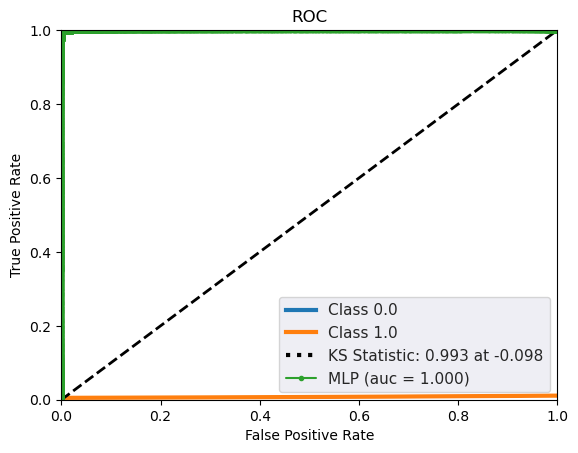

=== Starting Fold 2 ===


/home/pedro/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 110.42it/s]


Epoch 1/30 - Train Loss: 0.3221 - Val Loss: 0.0420 - Train Acc: 0.7556 - Val Acc: 0.9914 - LR: 0.001000 - Time: 45.17s


Epoch 2/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.30it/s]


Epoch 2/30 - Train Loss: 0.2280 - Val Loss: 0.0411 - Train Acc: 0.7732 - Val Acc: 0.9922 - LR: 0.001000 - Time: 42.71s


Epoch 3/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.65it/s]


Epoch 3/30 - Train Loss: 0.2273 - Val Loss: 0.0341 - Train Acc: 0.7735 - Val Acc: 0.9949 - LR: 0.001000 - Time: 42.73s


Epoch 4/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.84it/s]


Epoch 4/30 - Train Loss: 0.2243 - Val Loss: 0.0275 - Train Acc: 0.7746 - Val Acc: 0.9956 - LR: 0.001000 - Time: 42.61s


Epoch 5/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.82it/s]


Epoch 5/30 - Train Loss: 0.2242 - Val Loss: 0.0289 - Train Acc: 0.7745 - Val Acc: 0.9937 - LR: 0.001000 - Time: 42.75s


Epoch 6/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.41it/s]


Epoch 6/30 - Train Loss: 0.2240 - Val Loss: 0.0324 - Train Acc: 0.7749 - Val Acc: 0.9960 - LR: 0.001000 - Time: 42.69s


Epoch 7/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.40it/s]


Epoch 7/30 - Train Loss: 0.2239 - Val Loss: 0.0313 - Train Acc: 0.7747 - Val Acc: 0.9963 - LR: 0.001000 - Time: 42.68s


Epoch 8/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.67it/s]


Epoch 8/30 - Train Loss: 0.2248 - Val Loss: 0.0328 - Train Acc: 0.7738 - Val Acc: 0.9961 - LR: 0.001000 - Time: 42.72s


Epoch 9/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.54it/s]


Epoch 9/30 - Train Loss: 0.2231 - Val Loss: 0.0254 - Train Acc: 0.7743 - Val Acc: 0.9950 - LR: 0.000500 - Time: 42.82s


Epoch 10/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.15it/s]


Epoch 10/30 - Train Loss: 0.2229 - Val Loss: 0.0275 - Train Acc: 0.7745 - Val Acc: 0.9957 - LR: 0.000500 - Time: 42.78s


Epoch 11/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.72it/s]


Epoch 11/30 - Train Loss: 0.2233 - Val Loss: 0.0295 - Train Acc: 0.7750 - Val Acc: 0.9963 - LR: 0.000500 - Time: 42.70s


Epoch 12/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.32it/s]


Epoch 12/30 - Train Loss: 0.2226 - Val Loss: 0.0271 - Train Acc: 0.7750 - Val Acc: 0.9954 - LR: 0.000500 - Time: 42.75s


Epoch 13/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.50it/s]


Epoch 13/30 - Train Loss: 0.2230 - Val Loss: 0.0286 - Train Acc: 0.7745 - Val Acc: 0.9957 - LR: 0.000500 - Time: 42.81s


Epoch 14/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.02it/s]


Epoch 14/30 - Train Loss: 0.2224 - Val Loss: 0.0278 - Train Acc: 0.7749 - Val Acc: 0.9958 - LR: 0.000250 - Time: 42.81s


Epoch 15/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.19it/s]


Epoch 15/30 - Train Loss: 0.2225 - Val Loss: 0.0271 - Train Acc: 0.7753 - Val Acc: 0.9953 - LR: 0.000250 - Time: 42.94s


Epoch 16/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 114.89it/s]


Epoch 16/30 - Train Loss: 0.2219 - Val Loss: 0.0265 - Train Acc: 0.7754 - Val Acc: 0.9956 - LR: 0.000250 - Time: 42.94s


Epoch 17/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.77it/s]


Epoch 17/30 - Train Loss: 0.2215 - Val Loss: 0.0272 - Train Acc: 0.7758 - Val Acc: 0.9957 - LR: 0.000250 - Time: 42.89s


Epoch 18/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 117.53it/s]


Epoch 18/30 - Train Loss: 0.2220 - Val Loss: 0.0269 - Train Acc: 0.7753 - Val Acc: 0.9949 - LR: 0.000125 - Time: 42.66s


Epoch 19/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.41it/s]


Epoch 19/30 - Train Loss: 0.2217 - Val Loss: 0.0276 - Train Acc: 0.7755 - Val Acc: 0.9958 - LR: 0.000125 - Time: 42.79s
Early stopping triggered!
Fold 2 Results:
Accuracy: 0.9945, Recall: 0.9932, Precision: 0.9994, F1-Score: 0.9963, auroc: 0.9998


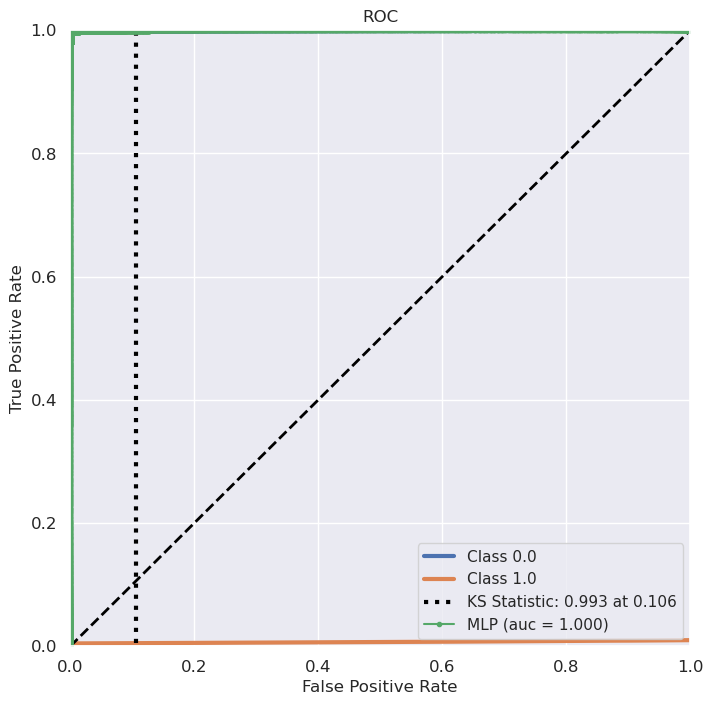

=== Starting Fold 3 ===


/home/pedro/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 109.61it/s]


Epoch 1/30 - Train Loss: 0.3572 - Val Loss: 0.0415 - Train Acc: 0.7588 - Val Acc: 0.9929 - LR: 0.001000 - Time: 44.87s


Epoch 2/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.24it/s]


Epoch 2/30 - Train Loss: 0.2276 - Val Loss: 0.0312 - Train Acc: 0.7725 - Val Acc: 0.9937 - LR: 0.001000 - Time: 42.85s


Epoch 3/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 114.06it/s]


Epoch 3/30 - Train Loss: 0.2263 - Val Loss: 0.0305 - Train Acc: 0.7738 - Val Acc: 0.9953 - LR: 0.001000 - Time: 42.90s


Epoch 4/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 114.58it/s]


Epoch 4/30 - Train Loss: 0.2257 - Val Loss: 0.0365 - Train Acc: 0.7743 - Val Acc: 0.9909 - LR: 0.001000 - Time: 42.95s


Epoch 5/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.37it/s]


Epoch 5/30 - Train Loss: 0.2244 - Val Loss: 0.0343 - Train Acc: 0.7747 - Val Acc: 0.9946 - LR: 0.001000 - Time: 42.95s


Epoch 6/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.96it/s]


Epoch 6/30 - Train Loss: 0.2236 - Val Loss: 0.0319 - Train Acc: 0.7742 - Val Acc: 0.9939 - LR: 0.001000 - Time: 42.86s


Epoch 7/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 114.31it/s]


Epoch 7/30 - Train Loss: 0.2511 - Val Loss: 0.0360 - Train Acc: 0.7708 - Val Acc: 0.9955 - LR: 0.001000 - Time: 42.90s


Epoch 8/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.80it/s]


Epoch 8/30 - Train Loss: 0.2237 - Val Loss: 0.0359 - Train Acc: 0.7753 - Val Acc: 0.9922 - LR: 0.000500 - Time: 42.94s


Epoch 9/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.75it/s]


Epoch 9/30 - Train Loss: 0.2227 - Val Loss: 0.0290 - Train Acc: 0.7754 - Val Acc: 0.9932 - LR: 0.000500 - Time: 42.91s


Epoch 10/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.43it/s]


Epoch 10/30 - Train Loss: 0.2231 - Val Loss: 0.0330 - Train Acc: 0.7748 - Val Acc: 0.9952 - LR: 0.000500 - Time: 42.84s


Epoch 11/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.82it/s]


Epoch 11/30 - Train Loss: 0.2231 - Val Loss: 0.0301 - Train Acc: 0.7746 - Val Acc: 0.9939 - LR: 0.000500 - Time: 42.89s


Epoch 12/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 116.30it/s]


Epoch 12/30 - Train Loss: 0.2231 - Val Loss: 0.0302 - Train Acc: 0.7746 - Val Acc: 0.9946 - LR: 0.000500 - Time: 42.80s


Epoch 13/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.82it/s]


Epoch 13/30 - Train Loss: 0.2221 - Val Loss: 0.0298 - Train Acc: 0.7753 - Val Acc: 0.9926 - LR: 0.000500 - Time: 42.82s


Epoch 14/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 114.20it/s]


Epoch 14/30 - Train Loss: 0.2226 - Val Loss: 0.0364 - Train Acc: 0.7744 - Val Acc: 0.9961 - LR: 0.000250 - Time: 42.88s


Epoch 15/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.93it/s]


Epoch 15/30 - Train Loss: 0.2225 - Val Loss: 0.0293 - Train Acc: 0.7742 - Val Acc: 0.9950 - LR: 0.000250 - Time: 42.86s


Epoch 16/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.04it/s]


Epoch 16/30 - Train Loss: 0.2230 - Val Loss: 0.0360 - Train Acc: 0.7740 - Val Acc: 0.9966 - LR: 0.000250 - Time: 42.84s


Epoch 17/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.46it/s]


Epoch 17/30 - Train Loss: 0.2224 - Val Loss: 0.0321 - Train Acc: 0.7742 - Val Acc: 0.9962 - LR: 0.000250 - Time: 42.82s


Epoch 18/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.10it/s]


Epoch 18/30 - Train Loss: 0.2214 - Val Loss: 0.0309 - Train Acc: 0.7753 - Val Acc: 0.9957 - LR: 0.000125 - Time: 42.85s


Epoch 19/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 115.78it/s]


Epoch 19/30 - Train Loss: 0.2209 - Val Loss: 0.0304 - Train Acc: 0.7755 - Val Acc: 0.9961 - LR: 0.000125 - Time: 42.83s
Early stopping triggered!
Fold 3 Results:
Accuracy: 0.9950, Recall: 0.9938, Precision: 0.9994, F1-Score: 0.9966, auroc: 0.9999


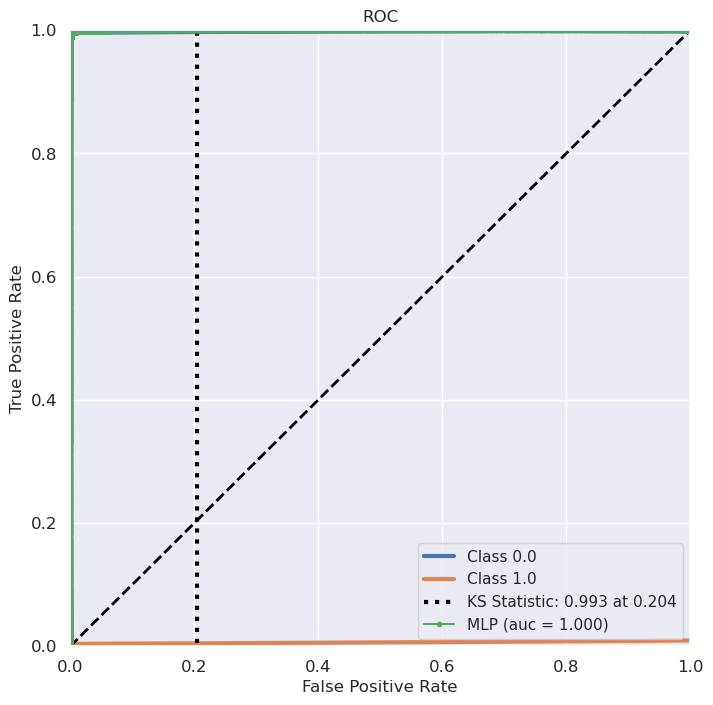

=== Starting Fold 4 ===


/home/pedro/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 105.78it/s]


Epoch 1/30 - Train Loss: 0.2788 - Val Loss: 0.0368 - Train Acc: 0.7606 - Val Acc: 0.9941 - LR: 0.001000 - Time: 44.90s


Epoch 2/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 110.61it/s]


Epoch 2/30 - Train Loss: 0.2265 - Val Loss: 0.0272 - Train Acc: 0.7739 - Val Acc: 0.9960 - LR: 0.001000 - Time: 43.53s


Epoch 3/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.96it/s]


Epoch 3/30 - Train Loss: 0.2244 - Val Loss: 0.0283 - Train Acc: 0.7744 - Val Acc: 0.9951 - LR: 0.001000 - Time: 43.39s


Epoch 4/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.03it/s]


Epoch 4/30 - Train Loss: 0.2219 - Val Loss: 0.0278 - Train Acc: 0.7759 - Val Acc: 0.9963 - LR: 0.001000 - Time: 43.26s


Epoch 5/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.73it/s]


Epoch 5/30 - Train Loss: 0.2227 - Val Loss: 0.0243 - Train Acc: 0.7749 - Val Acc: 0.9958 - LR: 0.001000 - Time: 43.16s


Epoch 6/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.60it/s]


Epoch 6/30 - Train Loss: 0.2227 - Val Loss: 0.0488 - Train Acc: 0.7751 - Val Acc: 0.9930 - LR: 0.001000 - Time: 43.09s


Epoch 7/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.86it/s]


Epoch 7/30 - Train Loss: 0.2293 - Val Loss: 0.0238 - Train Acc: 0.7727 - Val Acc: 0.9947 - LR: 0.001000 - Time: 43.10s


Epoch 8/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.71it/s]


Epoch 8/30 - Train Loss: 0.2227 - Val Loss: 0.0340 - Train Acc: 0.7745 - Val Acc: 0.9955 - LR: 0.001000 - Time: 43.11s


Epoch 9/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.15it/s]


Epoch 9/30 - Train Loss: 0.2224 - Val Loss: 0.0309 - Train Acc: 0.7756 - Val Acc: 0.9961 - LR: 0.001000 - Time: 43.18s


Epoch 10/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.51it/s]


Epoch 10/30 - Train Loss: 0.2226 - Val Loss: 0.0330 - Train Acc: 0.7748 - Val Acc: 0.9970 - LR: 0.001000 - Time: 43.05s


Epoch 11/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 110.26it/s]


Epoch 11/30 - Train Loss: 0.2224 - Val Loss: 0.0294 - Train Acc: 0.7748 - Val Acc: 0.9961 - LR: 0.001000 - Time: 43.18s


Epoch 12/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.99it/s]


Epoch 12/30 - Train Loss: 0.2214 - Val Loss: 0.0332 - Train Acc: 0.7755 - Val Acc: 0.9931 - LR: 0.000500 - Time: 43.16s


Epoch 13/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.47it/s]


Epoch 13/30 - Train Loss: 0.2210 - Val Loss: 0.0249 - Train Acc: 0.7754 - Val Acc: 0.9966 - LR: 0.000500 - Time: 43.20s


Epoch 14/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.73it/s]


Epoch 14/30 - Train Loss: 0.2221 - Val Loss: 0.0289 - Train Acc: 0.7740 - Val Acc: 0.9931 - LR: 0.000500 - Time: 43.19s


Epoch 15/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.58it/s]


Epoch 15/30 - Train Loss: 0.2216 - Val Loss: 0.0249 - Train Acc: 0.7754 - Val Acc: 0.9961 - LR: 0.000500 - Time: 43.20s
Early stopping triggered!
Fold 4 Results:
Accuracy: 0.9947, Recall: 0.9931, Precision: 0.9997, F1-Score: 0.9964, auroc: 0.9999


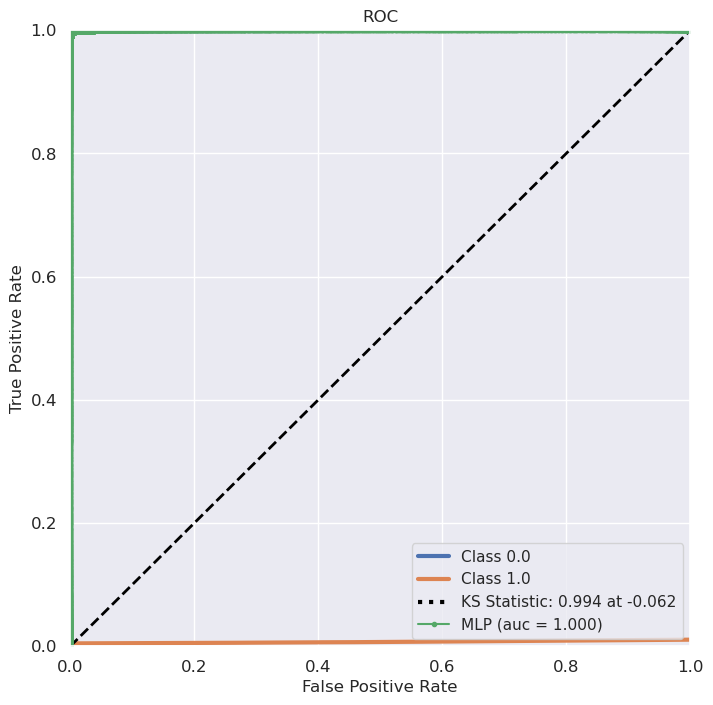

=== Starting Fold 5 ===


/home/pedro/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 109.22it/s]


Epoch 1/30 - Train Loss: 0.2936 - Val Loss: 0.0404 - Train Acc: 0.7582 - Val Acc: 0.9939 - LR: 0.001000 - Time: 44.84s


Epoch 2/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 110.60it/s]


Epoch 2/30 - Train Loss: 0.2332 - Val Loss: 0.0320 - Train Acc: 0.7725 - Val Acc: 0.9941 - LR: 0.001000 - Time: 43.18s


Epoch 3/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.80it/s]


Epoch 3/30 - Train Loss: 0.2271 - Val Loss: 0.0309 - Train Acc: 0.7738 - Val Acc: 0.9933 - LR: 0.001000 - Time: 43.22s


Epoch 4/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.15it/s]


Epoch 4/30 - Train Loss: 0.2306 - Val Loss: 0.0315 - Train Acc: 0.7729 - Val Acc: 0.9929 - LR: 0.001000 - Time: 43.11s


Epoch 5/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.32it/s]


Epoch 5/30 - Train Loss: 0.2251 - Val Loss: 0.0332 - Train Acc: 0.7739 - Val Acc: 0.9953 - LR: 0.001000 - Time: 43.17s


Epoch 6/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.29it/s]


Epoch 6/30 - Train Loss: 0.2254 - Val Loss: 0.0309 - Train Acc: 0.7738 - Val Acc: 0.9938 - LR: 0.001000 - Time: 43.23s


Epoch 7/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.02it/s]


Epoch 7/30 - Train Loss: 0.2248 - Val Loss: 0.0322 - Train Acc: 0.7745 - Val Acc: 0.9945 - LR: 0.001000 - Time: 43.10s


Epoch 8/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.38it/s]


Epoch 8/30 - Train Loss: 0.2256 - Val Loss: 0.0312 - Train Acc: 0.7744 - Val Acc: 0.9935 - LR: 0.001000 - Time: 43.11s


Epoch 9/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.81it/s]


Epoch 9/30 - Train Loss: 0.2251 - Val Loss: 0.0363 - Train Acc: 0.7743 - Val Acc: 0.9957 - LR: 0.001000 - Time: 43.16s


Epoch 10/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.46it/s]


Epoch 10/30 - Train Loss: 0.2240 - Val Loss: 0.0358 - Train Acc: 0.7752 - Val Acc: 0.9945 - LR: 0.001000 - Time: 43.07s


Epoch 11/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.44it/s]


Epoch 11/30 - Train Loss: 0.2241 - Val Loss: 0.0310 - Train Acc: 0.7737 - Val Acc: 0.9949 - LR: 0.000500 - Time: 43.15s


Epoch 12/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.38it/s]


Epoch 12/30 - Train Loss: 0.2234 - Val Loss: 0.0318 - Train Acc: 0.7746 - Val Acc: 0.9941 - LR: 0.000500 - Time: 43.11s


Epoch 13/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.77it/s]


Epoch 13/30 - Train Loss: 0.2233 - Val Loss: 0.0295 - Train Acc: 0.7754 - Val Acc: 0.9947 - LR: 0.000500 - Time: 43.10s


Epoch 14/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.19it/s]


Epoch 14/30 - Train Loss: 0.2232 - Val Loss: 0.0324 - Train Acc: 0.7753 - Val Acc: 0.9951 - LR: 0.000500 - Time: 43.15s


Epoch 15/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.44it/s]


Epoch 15/30 - Train Loss: 0.2238 - Val Loss: 0.0329 - Train Acc: 0.7742 - Val Acc: 0.9946 - LR: 0.000500 - Time: 43.22s


Epoch 16/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 113.13it/s]


Epoch 16/30 - Train Loss: 0.2227 - Val Loss: 0.0305 - Train Acc: 0.7754 - Val Acc: 0.9948 - LR: 0.000500 - Time: 43.12s


Epoch 17/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.49it/s]


Epoch 17/30 - Train Loss: 0.2235 - Val Loss: 0.0282 - Train Acc: 0.7749 - Val Acc: 0.9947 - LR: 0.000500 - Time: 43.06s


Epoch 18/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.89it/s]


Epoch 18/30 - Train Loss: 0.2233 - Val Loss: 0.0291 - Train Acc: 0.7749 - Val Acc: 0.9952 - LR: 0.000500 - Time: 43.10s


Epoch 19/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.36it/s]


Epoch 19/30 - Train Loss: 0.2233 - Val Loss: 0.0317 - Train Acc: 0.7746 - Val Acc: 0.9956 - LR: 0.000500 - Time: 43.09s


Epoch 20/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.61it/s]


Epoch 20/30 - Train Loss: 0.2238 - Val Loss: 0.0403 - Train Acc: 0.7745 - Val Acc: 0.9944 - LR: 0.000500 - Time: 43.19s


Epoch 21/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.21it/s]


Epoch 21/30 - Train Loss: 0.2231 - Val Loss: 0.0294 - Train Acc: 0.7753 - Val Acc: 0.9949 - LR: 0.000500 - Time: 43.19s


Epoch 22/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 111.78it/s]


Epoch 22/30 - Train Loss: 0.2226 - Val Loss: 0.0329 - Train Acc: 0.7748 - Val Acc: 0.9948 - LR: 0.000250 - Time: 43.18s


Epoch 23/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.74it/s]


Epoch 23/30 - Train Loss: 0.2228 - Val Loss: 0.0320 - Train Acc: 0.7745 - Val Acc: 0.9956 - LR: 0.000250 - Time: 43.10s


Epoch 24/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.46it/s]


Epoch 24/30 - Train Loss: 0.2231 - Val Loss: 0.0373 - Train Acc: 0.7744 - Val Acc: 0.9960 - LR: 0.000250 - Time: 43.20s


Epoch 25/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.88it/s]


Epoch 25/30 - Train Loss: 0.2236 - Val Loss: 0.0314 - Train Acc: 0.7737 - Val Acc: 0.9941 - LR: 0.000250 - Time: 43.11s


Epoch 26/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.89it/s]


Epoch 26/30 - Train Loss: 0.2227 - Val Loss: 0.0295 - Train Acc: 0.7749 - Val Acc: 0.9941 - LR: 0.000125 - Time: 43.10s


Epoch 27/30 [Val]: 100%|██████████| 503/503 [00:04<00:00, 112.68it/s]


Epoch 27/30 - Train Loss: 0.2222 - Val Loss: 0.0333 - Train Acc: 0.7754 - Val Acc: 0.9957 - LR: 0.000125 - Time: 43.14s
Early stopping triggered!
Fold 5 Results:
Accuracy: 0.9942, Recall: 0.9928, Precision: 0.9994, F1-Score: 0.9961, auroc: 0.9997


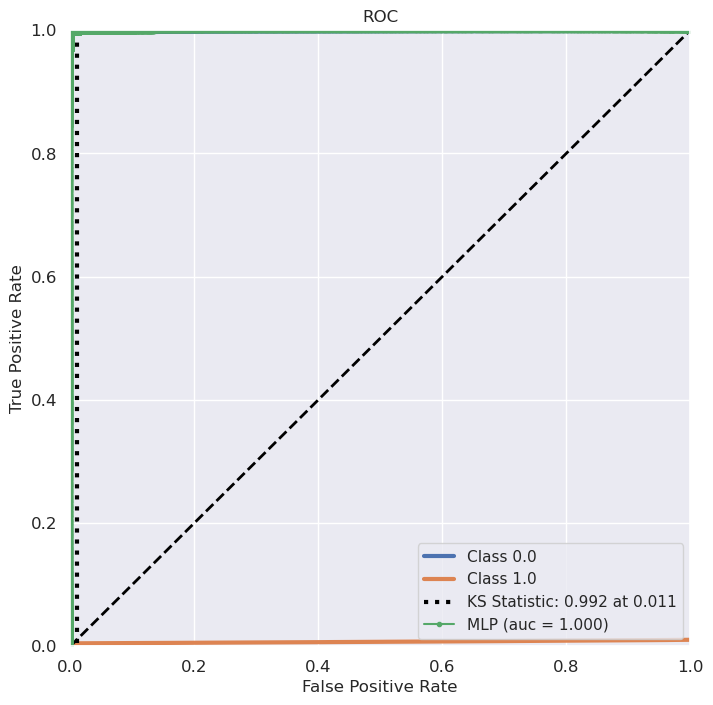

In [9]:
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações do KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 0
for train_idx, val_idx in kf.split(X, Y):
    fold_no += 1
    print(f"=== Starting Fold {fold_no} ===")
    
    # Criando o diretório para salvar os arquivos
    save_path = os.path.join(log_path, f"{fold_no}_fold")
    os.makedirs(save_path, exist_ok=True)

    # Dados de treino e validação
    x_train, x_val = X[train_idx], X[val_idx]
    y_train, y_val = Y[train_idx], Y[val_idx]

    # Convertendo para tensores do PyTorch
    x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

    # Criando DataLoaders
    batch_size = 256
    train_dataset = TensorDataset(x_train.unsqueeze(1), y_train)
    val_dataset = TensorDataset(x_val.unsqueeze(1), y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

    # Inicializando o modelo, loss e otimizador
    model = ConvNet().to(device)
    model.apply(init_weights)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # weight_decay é L2 no PyTorch
    scaler = torch.amp.GradScaler(device='cuda')  # Mixed Precision Training
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-5, verbose=True)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    # Treinando o modelo
    num_epochs = 30
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    l2_lambda = 0.01  # Regularização L2 (equivalente ao TensorFlow)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Criando o arquivo de log
        file_name = f'fold{fold_no}_log_{timestamp}.txt'
        file1 = open(os.path.join(save_path, file_name), "a")

        # Loop de treinamento com tqdm
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]")
        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):  # Mixed precision no forward pass
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)

            scaler.scale(loss).backward()  # Escala os gradientes
            scaler.step(optimizer)  # Atualiza os parâmetros
            scaler.update()  # Atualiza o escalador
            running_loss += loss.item()

            # Acurácia de treino
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (preds.squeeze() == targets).sum().item()
            total_train += targets.size(0)

            train_loop.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validação
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        y_preds, y_trues = [], []

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)
                with torch.amp.autocast(device_type='cuda'):  # Mixed precision também na validação
                    outputs = model(inputs)
                    val_loss += criterion(outputs.squeeze(), targets).item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (preds.squeeze() == targets).sum().item()
                total_val += targets.size(0)

                y_preds.extend(outputs.cpu().numpy())
                y_trues.extend(targets.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Calcula o tempo total da época
        epoch_time = time.time() - start_time

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
            f"Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f} - LR: {optimizer.param_groups[0]['lr']:.6f} - "
            f"Time: {epoch_time:.2f}s")

        scheduler.step(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Avaliação após cada fold
    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)

    # Converter para classes preditas
    y_pred_class = (y_preds > 0.5).astype(int)

    y_pred_scores2 = y_preds
    y_pred_scores_0 = 1 - y_preds
    y_pred_scores = np.column_stack((y_pred_scores_0, y_preds))
    #y_pred_scores = np.concatenate([y_pred_scores_0, y_preds], axis=1)
    
    # Calcular as métricas
    cm = confusion_matrix(y_trues, y_pred_class)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores, save_path)
    
    print(f"Fold {fold_no} Results:")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-Score: {f1:.4f}, auroc: {auroc:.4f}")

    # Salvar os valores no diretório do fold
    np.savez_compressed(
        os.path.join(save_path, f"fold_{fold_no}_y_val_y_pred_class_y_pred_scores.npz"),
        y_val=y_trues, y_pred_class=y_pred_class, y_pred_scores=y_pred_scores
    )

    print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

    # Plotar curvas de perda
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_path, "loss_and_val_loss.png"))
    plt.close()

    # Plotar acurácia
    plt.figure(figsize=(8, 4))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_path, "accuracy_and_val_accuracy.png"))
    plt.close()

    # Plotar matriz de confusão
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(save_path, "confusion_matrix.png"))
    plt.close()

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
    auc_keras = auc(fpr_keras, tpr_keras)

    # Plotar curva ROC
    sns.set(rc={'figure.figsize':(8,8)})
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig(save_path + "/plot_roc.png")
    plt.show()

    # Salvar o modelo
    torch.save(model.state_dict(), os.path.join(save_path, f"fold_{fold_no}_model.pth"))

    # Liberação de memória
    del model, x_train, x_val, y_train, y_val, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

In [10]:
y_pred_scores = np.column_stack((y_pred_scores_0, y_preds))
y_pred_scores

array([[ 3.656, -2.656],
       [ 4.297, -3.299],
       [ 1.691, -0.692],
       ...,
       [-5.12 ,  6.12 ],
       [-4.656,  5.656],
       [-4.152,  5.152]], dtype=float16)